In [ ]:
# default_exp core

# Core functions

> API details.

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.all import *
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Preprocces functions

## M4

In [ ]:
# export
def ts_lists(ts:np.ndarray)-> L:
    """From a `ndarray` of shape (timeseries, max_time) to a list of timeseries with shape (1,time).
    
    max_time = the lenght of the longest timeserie
    time = the lenght of the non-nan values of that specific timeserie    
    """
    lst = L()
    for time_series in ts:
        lst.append(time_series[~np.isnan(time_series)][None,:])
    return lst

In [ ]:
ts = np.array([np.arange(0,10.),
               np.arange(0,10.)
              ])
ts[1,-1] = np.NaN

test_eq(ts_lists(ts)[0],np.arange(0,10.)[None,:])
test_eq(ts_lists(ts)[1],np.arange(0,9.)[None,:])
test_eq(ts_lists(ts)[0].shape,(1,10))

## Gas-usage


In [ ]:
# export 

class ToElapsed():
    changed = False    
    def __call__(self, s):
        if pd.api.types.is_datetime64_any_dtype(s.dtype):            
            self.changed = True
            return s.astype(np.int64) // 10 ** 9
        return s
    
    def decode(self, s):
        if self.changed:    
            return pd.Series(pd.to_datetime(s *(10 ** 9)))
        return s
    

In [ ]:
pd.Series(pd.Timestamp('1970')).astype(np.int64)// 10 ** 9
s = pd.Series(pd.Timestamp('1970-1-1 01:00')).astype(np.int64)// 10 ** 9
pd.api.types.is_datetime64_any_dtype(s.dtype)

False

In [ ]:
tmf = ToElapsed()
test_eq(tmf(pd.Series([pd.Timestamp('1970')+pd.Timedelta(hours=1)*x for x in range(24)])),
       np.arange(0,3600*24,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*24,3600))),
        pd.Series([pd.Timestamp('1970')+pd.Timedelta(hours=1)*x for x in range(24)]))

test_eq_type(tmf.decode(pd.Series(np.arange(0,3600*24,3600)))[0], pd.Timestamp('1970'))


In [ ]:
tmf = ToElapsed()
test_eq(tmf(pd.Series(np.arange(0,3600*24,3600))),
       np.arange(0,3600*24,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*24,3600))),
       np.arange(0,3600*24,3600))

In [ ]:
# export
def make_interval(
    df: pd.DataFrame,
    to_split_col:str='datetime',
    interval=3600,
    max_splits=100000,
    callback_error=None,
) -> L(pd.DataFrame):
    """Will check if `df.datetime` has interval of `interval` in seconds. 
    
    if not will make it happen and return a list where this is done.
    """
    tmf = ToElapsed()
    df[to_split_col] = tmf(df[to_split_col])    
    df.index = df[to_split_col]
    df = df.sort_index()
    index = df.index.to_numpy()
    df["delta"] = abs(
        (df[to_split_col] - df[to_split_col].shift(1))
    )    
    mask = df["delta"] != interval
    starts = np.arange(len(mask))[mask]
    ends = list(starts[1:])+L(len(mask))
    
    del df["delta"]

    if len(ends) > max_splits:
        if callback_error:
            callback_error()
        raise Exception(
            f"number of splits {len(not_hour)} > {max_splits}: \n{not_hour}"
        )
    print(starts,ends)
    dfs = L()
    for start, end in zip(starts, ends):
        _df = df.iloc[start: end,:]
        _df.loc[:,to_split_col] = tmf.decode(_df[to_split_col])
        dfs.append(_df)

    return dfs

In [ ]:
df_start = pd.DataFrame({'dt':np.arange(0,10),
                  'x':np.arange(0,10),
                  })
df_end = pd.DataFrame({'dt':np.arange(15,20),
                  'x':np.arange(0,5) ,
                  })
df = df_start.append(df_end)

r = make_interval(df,'dt',1)

test_eq(len(r),2)

test_eq(r[0],df_start)
test_eq(r[1],df_end)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)


[ 0 10] (#2) [10,15]


In [ ]:
df_start = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-01')+pd.Timedelta(hours=1)*x for x in range(48)],
                  'x':np.arange(0,48),
                  })
df_end = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-04')+pd.Timedelta(hours=1)*x for x in range(24)],
                  'x':np.arange(0,24),
                  })
df = df_start.append(df_end)

r = make_interval(df,'datetime', 3600)
test_eq(len(r),2)

test_eq(r[0].values, df_start.values)
test_eq(r[1].values, df_end.values)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)


[ 0 48] (#2) [48,72]


In [ ]:
# export
def melted_ts_2_lists(ts:pd.DataFrame, melted_col_name:str, **kwargs)->L:
    dfs = L()
    for c in set(ts[melted_col_name]):
        _df = ts[ts[melted_col_name] == c]
        r = make_interval(_df,**kwargs)
        dfs += r
    return dfs

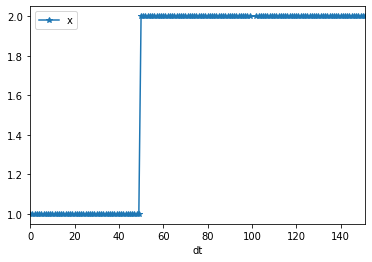

In [ ]:
df_start = pd.DataFrame({'dt':np.arange(0,100),
                  'x':L([1]*50) + L([2]*50),
                  })
df_end = pd.DataFrame({'dt':np.arange(102,152),
                  'x':L([2]*50) ,
                  })
df = df_start.append(df_end)
df.plot(x='dt',y='x',marker='*')

In [ ]:
r = melted_ts_2_lists(df,'x',to_split_col='dt',interval=1)
test_eq(type(r), type(L(0)))
test_eq(len(r), 3)

test_eq_type(r[2], df_end)

test_eq(r[0].shape, (50,2))
test_eq(r[1].shape, (50,2))
test_eq(r[2].shape, (50,2))

[0] (#1) [50]
[ 0 50] (#2) [50,100]


/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Fin

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
This cell doesn't have an export destination and was ignored:
 
Converted 02_deep4cast_m4_example.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted index.ipynb.
